# Load models

In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

cwd = os.getcwd()
module_path = "/".join(cwd.split('/')[0:-1])
if module_path not in sys.path:
    sys.path.append(module_path)

# Network architectures
from net.resnet import resnet50

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
# Load ResNet-18 model
resnet50_sn_model = resnet50(spectral_normalization=True,
                             mod = False,
                             mnist = False,
                             num_classes=2).to(device)
resnet50_sn_model = nn.DataParallel(resnet50_sn_model, device_ids=range(torch.cuda.device_count()))
resnet50_sn_model.load_state_dict(torch.load('/home/shpark/DDU/resnet50_100_0.592_86_best.pth'))

<All keys matched successfully>

# Compute softmax entropy & feature density

In [10]:
from tqdm import tqdm
import data.fashion_mnist as fashion_mnist # for completely odd dataset
from colon_data import get_train_valid_loader, get_test_loader, get_ood_test_loader

import metrics.uncertainty_confidence as uncertainty_confidence

from utils.gmm_utils import get_embeddings, gmm_fit, gmm_evaluate

In [11]:
num_classes = 2
batch_size = 64

# Colonoscopy data loader
colon_train_loader, colon_val_loader = get_train_valid_loader(root="/home/shpark/Colonoscopy_Dataset/Train(SNUH)/",
                                                                          batch_size=batch_size,
                                                                          augment=False,
                                                                          val_seed = 1)
colon_test_loader = get_test_loader(root="/home/shpark/Colonoscopy_Dataset/Train(SNUH)/",
                                     batch_size=batch_size)
colon_ood_loader = get_ood_test_loader(root="/home/shpark/Colonoscopy_Dataset/SSL_SP",
                                     batch_size=batch_size)

# Fashion MNIST data loader
fashion_mnist_loader = fashion_mnist.get_loaders(batch_size=batch_size,
                                                 train=False)

In [12]:
def get_logits (model, data_loader, device):
    logits = []
    model.eval()
    with torch.no_grad():
        for (data, label) in tqdm(data_loader):
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            logits.append(output)
        
    logits = torch.cat(logits, dim=0)
    return logits


def train_gmm(model, num_dim, train_loader, device):
    embeddings, labels = get_embeddings(model,
                                        train_loader,
                                        num_dim,
                                        dtype=torch.double,
                                        device=device,
                                        storage_device=device)
    gaussians_model, jitter_eps = gmm_fit(embeddings=embeddings,
                                          labels=labels,
                                          num_classes=10)
    return gaussians_model


def get_gmm_logits(model, gmm_model, data_loader, device):
    gmm_logits, gmm_labels = gmm_evaluate(model,
                                          gmm_model,
                                          data_loader,
                                          device=device,
                                          num_classes=10,
                                          storage_device=device)
    return gmm_logits

In [13]:
# Computing entropies for ResNet50-SN
resnet50_sn_colon_entropies = uncertainty_confidence.entropy(
    get_logits(resnet50_sn_model, colon_test_loader, device)
)
resnet50_sn_colon_ood_entropies = uncertainty_confidence.entropy(
    get_logits(resnet50_sn_model, colon_ood_loader, device)
)
# resnet50_sn_fashion_mnist_entropies = uncertainty_confidence.entropy(
#     get_logits(resnet50_sn_model, fashion_mnist_loader, device)
# )

# Computing GMM densities for resnet50_sn
resnet50_sn_gmm_model = train_gmm(resnet50_sn_model, 2048, colon_train_loader, device)
resnet50_sn_colon_densities = uncertainty_confidence.logsumexp(
    get_gmm_logits(resnet50_sn_model, resnet50_sn_gmm_model, colon_test_loader, device)
)
resnet50_sn_colon_ood_densities = uncertainty_confidence.logsumexp(
    get_gmm_logits(resnet50_sn_model, resnet50_sn_gmm_model, colon_ood_loader, device)
)
# resnet50_sn_fashion_mnist_densities = uncertainty_confidence.logsumexp(
#     get_gmm_logits(resnet50_sn_model, resnet50_sn_gmm_model, fashion_mnist_loader, device)
# )

 33%|███▎      | 2/6 [00:01<00:03,  1.31it/s]

  0%|          | 0/6 [00:02<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'log_prob'

# Plot softmax entropy & feature density

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
from matplotlib import rc

In [ ]:
from dataclasses import dataclass

os.makedirs("./pdfs")
os.makedirs("./pngs")

@dataclass
class Results:
    colon: np.array
    colon_ood: np.array
    # ambiguous_mnist: np.array
    # fashion_mnist: np.array
    # dirty_mnist: pd.DataFrame

# lenet_dirty_mnist_entropies = torch.load('lenet_dirty_mnist_entropies.pt').cpu().numpy()
# This is for ambiguous data
# def combine_dirty_mnist(mnist, ambiguous_mnist):
#     dirty_mnist = np.concatenate((mnist, ambiguous_mnist))
#     dirty_mnist_categories = np.concatenate((np.zeros_like(mnist, dtype=np.int8), np.ones_like(ambiguous_mnist, dtype=np.int8)))

#     df = pd.DataFrame(dict(entropy=dirty_mnist, category=dirty_mnist_categories))
#     return df

In [ ]:
resnet50_sn_entropy = Results(
    resnet50_sn_colon_entropies.cpu(),
    resnet50_sn_colon_ood_entropies.cpu(),
    # resnet50_sn_fashion_mnist_entropies.cpu(),
    # combine_dirty_mnist(resnet50_sn_colon_entropies.cpu(), resnet50_sn_colon_ood_entropies.cpu())
)

# resnet50_sn_density = Results(
#     resnet50_sn_colon_densities.cpu(),
#     resnet50_sn_colon_ood_densities.cpu(),  
#     # resnet50_sn_fashion_mnist_densities.cpu(),
#     # combine_dirty_mnist(resnet50_sn_colon_ood_densities.cpu(), np.array([]))
# )


In [ ]:
clrs = ['#1f77b4','#ff7f0e', '#2ca02c','#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22','#17becf']

sb.set_style('whitegrid')
sb.set_context("paper", font_scale=1, rc={"lines.linewidth": 2.5})

rc('text', usetex=False)

/tmp/ipykernel_2115023/85285748.py:8: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.30)  # adjust space between axes


RuntimeError: Tensor.__contains__ only supports Tensor or scalar, but you passed in a <class 'str'>.

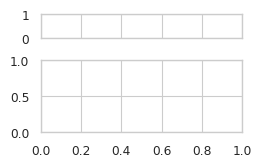

In [ ]:
def plot_entropy(results, separate_ID=False):
    common_kwargs = dict(stat='probability', kde=False, bins=12, binrange=[0,2.4], label="dummy", legend=False, element="step", alpha=0.7)
    id_kwargs = dict(
              hue="category", multiple="stack", 
              palette=[sb.color_palette()[0], sb.color_palette()[4]]) if separate_ID else dict(color=sb.color_palette()[0]) 

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(2.5,2.5/1.6), gridspec_kw={'height_ratios': [1, 3]}, constrained_layout=True)
    fig.subplots_adjust(hspace=0.30)  # adjust space between axes

    for ax in axes:
        sb.histplot(data=results.colon, x="entropy", **id_kwargs,
                    **common_kwargs, ax=ax)
        sb.histplot(results.colon_ood, color=sb.color_palette()[1],
                    **common_kwargs, ax=ax)

    axes[0].set_ylim(0.4, 0.55)  # outliers only
    axes[1].set_ylim(0, .15)  # most of the data

    axes[0].spines['bottom'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[0].set_ylabel("")
    axes[1].set_ylabel("Fraction", fontsize=12)
    axes[1].set_xlabel("Entropy", fontsize=12)

    axes[1].yaxis.set_label_coords(-0.04, 0.5, fig.transFigure)

    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    axes[0].plot([0, 1], [0, 0], transform=axes[0].transAxes, **kwargs)
    axes[1].plot([0, 1], [1, 1], transform=axes[1].transAxes, **kwargs)

    fig.set_size_inches(2.5,2.5/1.6)

    return fig, axes

separate_ID = False

fig, axes = plot_entropy(resnet50_sn_entropy, separate_ID=separate_ID)
plt.savefig('pdfs/entropy_hist_resnet50_colon_vs_ood_colon.pdf', bbox_inches='tight')
plt.savefig('pngs/entropy_hist_resnet50_colon_vs_ood_colon.png', bbox_inches='tight')

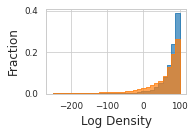

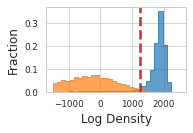

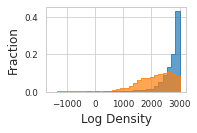

In [ ]:
def plot_density(results: Results, binrange, separate_ID=False):
    clrs = ['#1f77b4','#ff7f0e', '#2ca02c','#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22','#17becf']
    sb.set_style('whitegrid')

    plt.figure(figsize=(2.5,2.5/1.6))
    plt.tight_layout()

    range = dict(bins=30, binrange=binrange, element="step", fill=True, alpha=0.7)
    kw_separate_id = dict(hue="category", multiple="stack",
                hue_order=[1, 0],
                palette=[sb.color_palette()[4], sb.color_palette()[0]]) if separate_ID else dict(color=sb.color_palette()[0])

    sb.histplot(data=results.dirty_mnist, x="entropy", **kw_separate_id,
                stat='probability', kde=False, **range, label="dummy", legend=False) # 'Dirty-MNIST (In-distribution)')
    sb.histplot(results.fashion_mnist, color=sb.color_palette()[1],
                stat='probability', kde=False, **range, label="dummy", legend=False) #, label='Fashion-MNIST (OoD)')


    plt.xlabel('Log Density', fontsize=12)
    plt.ylabel('Fraction', fontsize=12)

plot_density(resnet50_sn_density,  binrange=[-1500, 2500], separate_ID=separate_ID)
plt.axvline(1250, color=clrs[3], linestyle='dashed', linewidth=2.5)
plt.savefig('pdfs/logdensity_hist_resnet18_sn_dirty_mnist_vs_fmnist.pdf', bbox_inches='tight')
plt.savefig('pngs/logdensity_hist_resnet18_sn_dirty_mnist_vs_fmnist.png', bbox_inches='tight')

In [14]:
# LeNet entropy plots Figure 1
sb.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (20, 6)
plt.rcParams["legend.loc"] = 'upper right'

sb.histplot(resnet50_sn_colon_entropies.cpu().numpy(), color=clrs[2], 
            stat='probability', kde=False, bins=15, line_kws = {'linewidth': 8}, label='Colon')
sb.histplot(resnet50_sn_colon_ood_entropies.cpu().numpy(), color=clrs[4], 
            stat='probability', kde=False, bins=15, line_kws = {'linewidth': 8}, label='OOD_Colon')

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('Entropy', fontsize=30)
plt.ylabel('Fraction', fontsize=30)
plt.legend(fontsize=30)
plt.savefig('pdfs/entropy_hist_resnet50_colon_vs_ood_colon.pdf', bbox_inches='tight')
plt.savefig('pngs/entropy_hist_resnet50_colon_vs_ood_colon.png', bbox_inches='tight')

NameError: name 'sb' is not defined

# Calibration Plot for Colonoscopy Data

In [15]:
from metrics.classification_metrics import test_classification_net
from metrics.calibration_metrics import reliability_plot
from utils.temperature_scaling import ModelWithTemperature

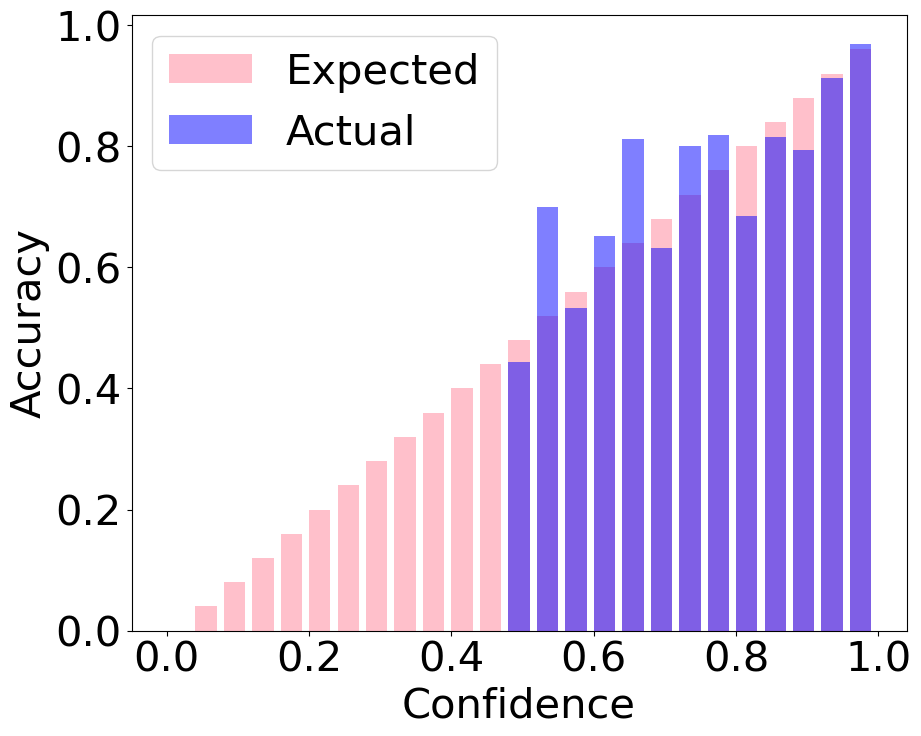

In [16]:
# Reliability plot for ResNet-50_SN
conf_matrix, accuracy, labels, predictions, confidences = test_classification_net(resnet50_sn_model, colon_test_loader, device)
reliability_plot(confidences, predictions, labels, num_bins=25, model_name="resnet50_sn")

Before temperature - NLL: 0.383, ECE: 0.044
Optimal temperature: 1.000
After temperature - NLL: 0.383, ECE: 0.044


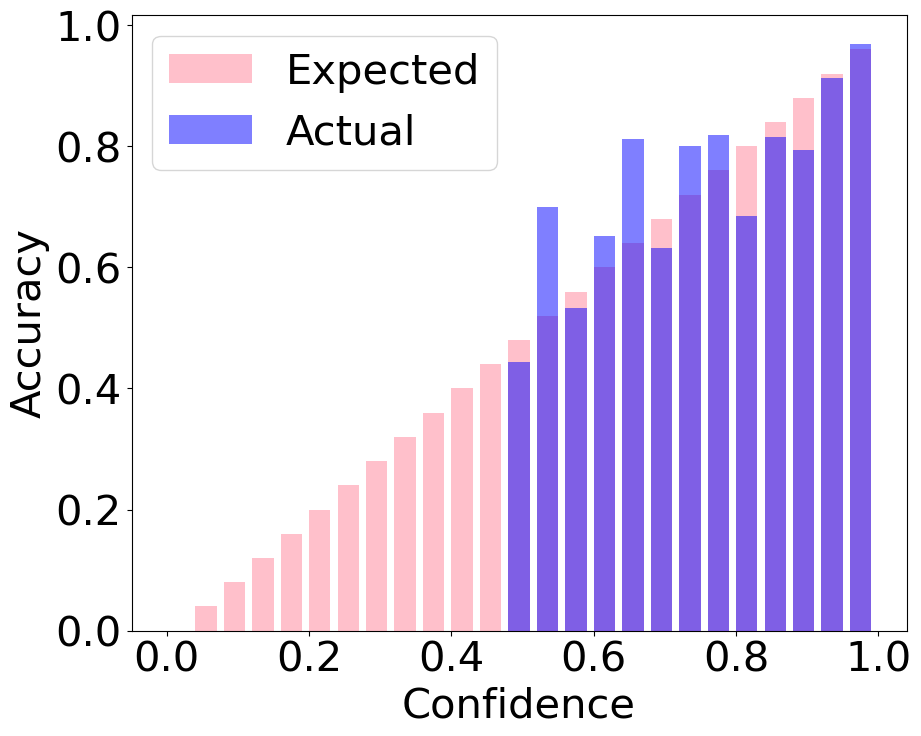

In [17]:
# Reliability plot for resnet50_sn post temp scaling
resnet50_sn_temp_model = ModelWithTemperature(resnet50_sn_model)
resnet50_sn_temp_model.set_temperature(colon_val_loader)
conf_matrix, accuracy, labels, predictions, confidences = test_classification_net(resnet50_sn_temp_model, colon_test_loader, device)
reliability_plot(confidences, predictions, labels, num_bins=25, model_name="resnet50_sn")